The source code is in the public domain and not licensed or under
copyright. The information and software may be used freely by the public.
As required by 17 U.S.C. 403, third parties producing copyrighted works
consisting predominantly of the material produced by U.S. government
agencies must provide notice with such work(s) identifying the U.S.
Government material incorporated and stating that such material is not
subject to copyright protection.

Derived works shall not identify themselves in a manner that implies an
endorsement by or an affiliation with the Naval Research Laboratory.

RECIPIENT BEARS ALL RISK RELATING TO QUALITY AND PERFORMANCE OF THE
SOFTWARE AND ANY RELATED MATERIALS, AND AGREES TO INDEMNIFY THE NAVAL
RESEARCH LABORATORY FOR ALL THIRD-PARTY CLAIMS RESULTING FROM THE ACTIONS
OF RECIPIENT IN THE USE OF THE SOFTWARE.

In [1]:
import sys
sys.path.append('../../modules')
import numpy as np
from matplotlib import pyplot as plt
import photoionization_base as izbase
import ionization as iz
import input_tools

In [2]:
# In the following, by using the wrappers we keep everything in simulation units.
# One can also work with classes in photoionization_base, in which case only mks and atomic units are involved.
mks_length = 0.8e-6/(2*np.pi)
uc = iz.UnitTranslation(mks_length)
dnum = input_tools.InputHelper(mks_length).dnum
terms = 40
Z = 0.53
Uion = dnum('12.1 eV')
ws = 1.0 # simulation units
plugin = iz.PMPB(mks_length,True,Uion,Z,lstar=0,l=0,m=0,w0=ws,terms=terms)
ionizer = iz.Ionizer(plugin)

In [3]:
intensity = dnum('4e14 W/cm2')
tau_L = dnum('25 fs')
time_window = 4*tau_L
Nt = 512
Nx = 4
Ny = 4
E0 = (2*intensity)**0.5
print('E0 =',ionizer.field_sim_to_au(E0),'a.u.')
dt = time_window/Nt
t0 = time_window/2
t = np.einsum('i,j,k',np.linspace(0,(Nt-1)*dt,Nt),np.ones(Nx),np.ones(Ny))
EField = E0*np.exp(-(t-t0)**2/tau_L**2)

E0 = 0.1067605354227535 a.u.


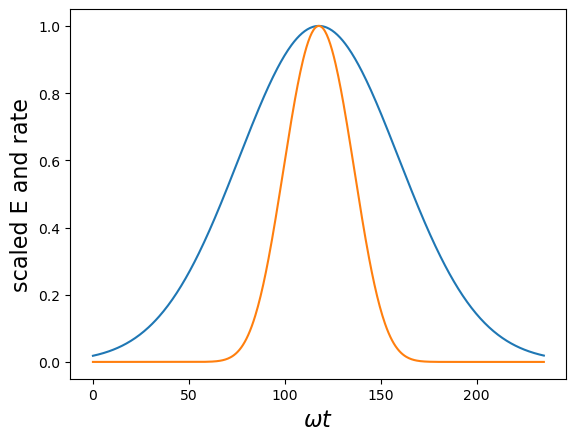

In [4]:
rate = ionizer.Rate(EField)
plt.plot(t[:,0,0],EField[:,0,0]/E0,t[:,0,0],rate[:,0,0]/np.max(rate))
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'scaled E and rate',fontsize=16)
plt.show()

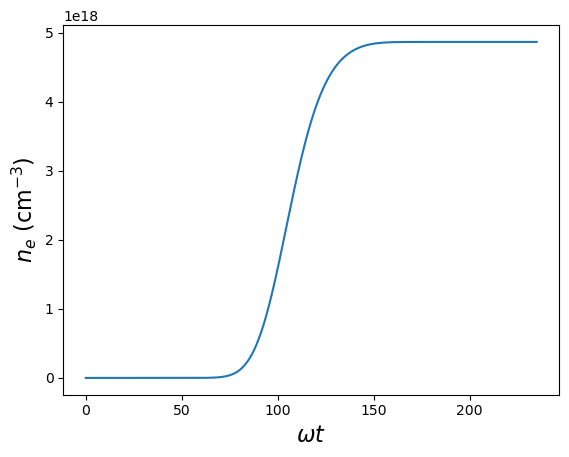

In [5]:
# Look at electron density, including saturation
# We can put the gas density in any units, electron density will come out in the same units
ng = 5.4e18*np.ones(EField.shape[1:])
ne = iz.GetPlasmaDensity(rate,ng,dt)[::-1]
plt.plot(t[:,0,0],ne[:,0,0])
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'$n_e$ (cm$^{-3}$)',fontsize=16)
plt.show()

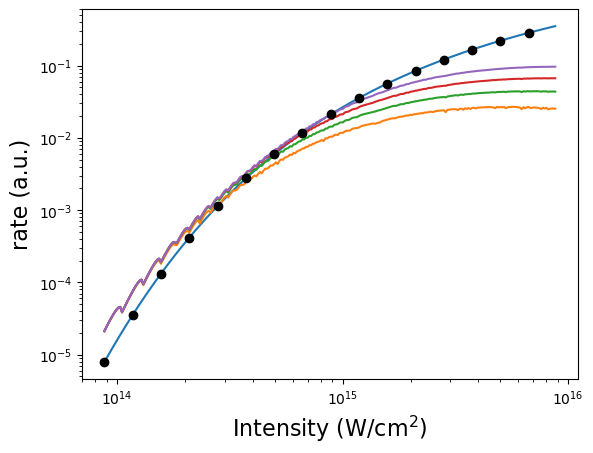

In [6]:
# Examine (non)convergence of PPT expansion
# Also overlay stitched rate
# Here we will also show how to mix lower (izbase) and higher (iz) level objects
Ua = uc.energy_sim_to_au(Uion)
wa = uc.rate_sim_to_au(ws)
ionizer0 = izbase.PPT_Tunneling(True,Ua,Z)
ionizer1 = izbase.PPT(True,Ua,Z,lstar=0,l=0,m=0,w0=wa,terms=10)
ionizer2 = izbase.PPT(True,Ua,Z,lstar=0,l=0,m=0,w0=wa,terms=20)
ionizer3 = izbase.PPT(True,Ua,Z,lstar=0,l=0,m=0,w0=wa,terms=40)
ionizer4 = izbase.PPT(True,Ua,Z,lstar=0,l=0,m=0,w0=wa,terms=80)
# This object gets the rate directly
stitched_plugin = izbase.StitchedPPT(True,Ua,Z,lstar=0,l=0,m=0,w0=wa,terms=80)
# This object uses a fit to the rate
stitched = iz.Ionizer(stitched_plugin,mks_length=mks_length)
E_table = np.logspace(np.log10(.05),np.log10(0.5),256)

tunn_rate_table = ionizer0.Rate(E_table)
rate1_table = ionizer1.Rate(E_table)
rate2_table = ionizer2.Rate(E_table)
rate3_table = ionizer3.Rate(E_table)
rate4_table = ionizer4.Rate(E_table)
# N.b. the higher level object needs some unit translations
# since it is designed to work directly in simulation units.
stitched_table = stitched.rate_sim_to_au(stitched.Rate(stitched.field_au_to_sim(E_table)))

E_mks = uc.field_to_mks(E_table)
intensity_Wcm2 = 1e-4 * E_mks**2 / (2*377)
plt.loglog(intensity_Wcm2,tunn_rate_table)
plt.loglog(intensity_Wcm2,rate1_table)
plt.loglog(intensity_Wcm2,rate2_table)
plt.loglog(intensity_Wcm2,rate3_table)
plt.loglog(intensity_Wcm2,rate4_table)
plt.loglog(intensity_Wcm2[::16],stitched_table[::16],'ko')
plt.xlabel(r'Intensity (W/cm$^2$)',fontsize=16)
plt.ylabel(r'rate (a.u.)',fontsize=16)
plt.show()

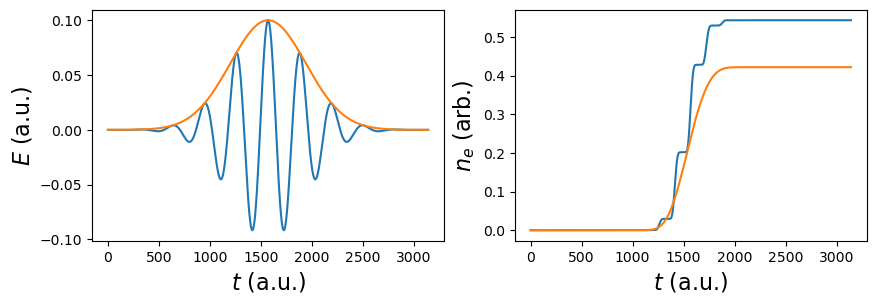

In [7]:
# Compare carrier resolved and enveloped ionization.
# Ideally these match up in the tunneling limit, but in practice they only match
# at a single point due to slow convergence (see above)
# This can also be used to tell us something about discretization errors.
# For this we stay in the lower level module and use atomic units.
# Exception is that the density comes from the higher level module.
E0 = 0.1
wa = 0.02
time_window = 10*2*np.pi/wa
Nt = 4096
Nx = 4
Ny = 4
dt = time_window/Nt
t0 = time_window/2
tau_L = time_window/6
t = np.einsum('i,j,k',np.linspace(0,(Nt-1)*dt,Nt),np.ones(Nx),np.ones(Ny))
EField = E0*np.exp(-(t-t0)**2/tau_L**2)*np.cos(wa*t)
# We may be interested to add some second harmonic and see what happens
EField += 0.0*E0*np.exp(-(t-t0)**2/tau_L**2)*np.cos(2*wa*t+np.pi/2)

uppe = izbase.PPT_Tunneling(False,Ua,Z)
para = izbase.PPT(True,Ua,Z,lstar=0,l=0,m=0,w0=wa,terms=80)
amp,phase,wa = izbase.ExtractEikonalForm(EField,dt)
uppe_rate = uppe.Rate(EField)
para_rate = para.Rate(amp)

ng = np.ones(EField.shape[1:])
para_ne = iz.GetPlasmaDensity(para_rate,ng,dt)[::-1]
uppe_ne = iz.GetPlasmaDensity(uppe_rate,ng,dt)[::-1]
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(t[:,0,0],EField[:,0,0],t[:,0,0],amp[:,0,0])
plt.xlabel(r'$t$ (a.u.)',fontsize=16)
plt.ylabel(r'$E$ (a.u.)',fontsize=16)
plt.subplot(122)
plt.plot(t[:,0,0],uppe_ne[:,0,0],t[:,0,0],para_ne[:,0,0])
plt.xlabel(r'$t$ (a.u.)',fontsize=16)
plt.ylabel(r'$n_e$ (arb.)',fontsize=16)
plt.show()